# 侦测走神司机

在此项目中，你将对 [数据集](https://www.kaggle.com/c/state-farm-distracted-driver-detection) 中的驾驶员状态图片进行分类。该数据集包含驾驶员十种状态下的图片。你需要预处理这些图片，然后用所有样本训练一个卷积神经网络。图片需要标准化（normalized），标签需要采用 one-hot 编码。你需要应用所学的知识构建卷积的、最大池化（max pooling）、丢弃（dropout）和完全连接（fully connected）的层。最后，你需要在样本图片上看到神经网络的预测结果。

## 获取图片

请运行以下单元，以下载 [数据集](https://www.kaggle.com/c/state-farm-distracted-driver-detection/)。将下载后的ZIP格式数据集解压到对应的目录

In [2]:
from urllib.request import urlretrieve 
from os.path import isfile, isdir 
from tqdm import tqdm 
import zipfile 
import csv
import os
import math  
import numpy as np  
import tensorflow as tf  
import matplotlib.pyplot as plt     
from PIL import Image
from sklearn.model_selection import KFold


cwd = os.getcwd()
print (cwd)

#图片CSV列表的数据 
DRIVER_IMGS_LIST_CVS_DATE_FILE = "distracted_driver_detection_dataset/driver_imgs_list.csv"
#图片的数据目录 
DRIVER_IMGES_DATASET_FOLDER_PATH = 'distracted_driver_detection_dataset/imgs'
#图片的ZIP位置 
DRIVER_IMGES_DATASET_LOCATION = 'distracted_driver_detection_dataset/imgs.zip'
#图片训练集目录
TRAIN_DIR = DRIVER_IMGES_DATASET_FOLDER_PATH+'/train' 
#图片测试集目录
TEST_DIR = DRIVER_IMGES_DATASET_FOLDER_PATH+'/test' 
#训练好的模型位置
SAVE_MODEL_PATH = './saved_model/model.ckpt'


csv_file = csv.reader(open(DRIVER_IMGS_LIST_CVS_DATE_FILE,'r'))

if isfile(DRIVER_IMGES_DATASET_LOCATION): 
    zip_path = DRIVER_IMGES_DATASET_LOCATION 
else: 
    zip_path = 'imgs.zip'

        
if not isfile(zip_path): 
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Dataset') as pbar:
        urlretrieve( 'https://www.kaggle.com/c/state-farm-distracted-driver-detection/data/imgs.zip', 
                    zip_path, 
                    pbar.hook)
        
#查看数据集imgs.zip是否已存在,解压到对应目录 
if not isdir(DRIVER_IMGES_DATASET_FOLDER_PATH): 
    with zipfile.ZipFile(zip_path) as zin: 
        zin.extractall(DRIVER_IMGES_DATASET_FOLDER_PATH) 
        zin.close()
        
print("所有原始文件已存在")

E:\pythonProject\machineLearningProgress\distracted_driver_detection
所有原始文件已存在


## 对图片进行数据处理

请运行以下单元，将从文件夹中读取所有的图片列表制作数据集

In [11]:
#读取CVS数据生成驾驶员信息、图片路径和标签的LIST 
def read_cvs_files(csv_file_path):    
    reade_csv_file = csv.reader(open(csv_file_path,'r'))
    driver_list = []
    image_list = [] 
    label_list = []
    for index,row in enumerate(reade_csv_file):
        if index > 0:
            driver_list.append(int(row[0].replace('p','')))
            label_list.append(int(row[1].replace('c','')))
            image_list.append(DRIVER_IMGES_DATASET_FOLDER_PATH+"/train/"+row[1]+"/"+row[2])
    return driver_list,image_list,label_list
    
get_driver_list,get_image_list,get_label_list = read_cvs_files(DRIVER_IMGS_LIST_CVS_DATE_FILE)

In [12]:
def create_record(image_list,label_list,driver_list):
    #驾驶员Id
    driverId = 2
    #存放图片个数
    bestnum = 100
    #第几个图片
    num = 0
    #第几个TFRecord文件
    recordfilenum = 0

    if isfile("distracted_driver_detection_dataset/driverData.tfrecords-002"): 
        print("已生成Tfrecord文件")
    else:
        new_file_date_name = ("distracted_driver_detection_dataset/driverData.tfrecords-%.3d"%driverId)
        print(new_file_date_name)
        writer = tf.python_io.TFRecordWriter(new_file_date_name) 
        
        for index,img_path in enumerate(image_list):
            if driver_list[index]>driverId:       
                driverId = driver_list[index]
                new_file_date_name = ("distracted_driver_detection_dataset/driverData.tfrecords-%.3d"%driverId)
                print(new_file_date_name)
                writer = tf.python_io.TFRecordWriter(new_file_date_name)
            num = num +1
            
            img=Image.open(img_path,'r') 
            size = img.size 
            img_raw = img.tobytes()      #将图one_hot_encode片转化为原生bytes
            
            #size = img.size
            example = tf.train.Example( 
                features=tf.train.Features(feature={ 
                'driver': tf.train.Feature(int64_list=tf.train.Int64List(value=[driver_list[index]])), 
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label_list[index]])), 
                'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])), 
                'img_width':tf.train.Feature(int64_list=tf.train.Int64List(value=[size[0]])), 
                'img_height':tf.train.Feature(int64_list=tf.train.Int64List(value=[size[1]])) 
            }))  
            writer.write(example.SerializeToString())
        writer.close()
        print( "all tfrecordfile is done!")

create_record(get_image_list,get_label_list,get_driver_list)

已生成Tfrecord文件


In [13]:
def read_and_decode(filename):   
    filename_queue = tf.train.string_input_producer(filename,shuffle=False)  
    #filename_queue = tf.train.string_input_producer([filename])  
    reader = tf.TFRecordReader() 
    _, serialized_example = reader.read(filename_queue)   #返回文件名和文件 
    features = tf.parse_single_example(serialized_example, 
                                       features={ 
                                           'driver': tf.FixedLenFeature([], tf.int64), 
                                           'label': tf.FixedLenFeature([], tf.int64), 
                                           'img_raw' : tf.FixedLenFeature([], tf.string) ,
                                           'img_width': tf.FixedLenFeature([], tf.int64), 
                                           'img_height': tf.FixedLenFeature([], tf.int64), 
                                       })  #取出包含image和label的feature对象 
    #tf.decode_raw可以将字符串解析成图像对应的像素数组     
    driver = tf.cast(features['driver'], tf.int32) 
    image = tf.decode_raw(features['img_raw'], tf.uint8)
    label = tf.cast(features['label'], tf.int32) 
    height = tf.cast(features['img_height'],tf.int32) 
    width = tf.cast(features['img_width'],tf.int32) 

    channel = 3 
    image = tf.reshape(image, [480,640,3])
    
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)  

    return driver,image,label

#train01_filename='E:\\pythonProject\\machineLearningProgress\\distracted_driver_detection\\distracted_driver_detection_dataset\\driverTrainData.tfrecords-000'
#file_img, file_label = read_and_decode([train01_filename])

In [14]:
#将图像和标签数据通过 tf.train.batch 整理成神经网络训练时需要的batch
def getBatch(filename,batch_size,capacity):    
    file_driver,file_img, file_label = read_and_decode(filename)
    driver_batches,image_batches,label_batches = tf.train.batch([file_driver,file_img, file_label], batch_size=batch_size, capacity=capacity)
    return driver_batches,image_batches,label_batches

In [15]:
# 创建编码器
from sklearn import preprocessing
nb_classes = 10
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]
# Create the encoder 创建编码器
lb = preprocessing.LabelBinarizer() 
def one_hot_encode(y):
    labels = indices_to_one_hot(y,nb_classes)
    # 编码器找到类别并分配 one-hot 向量
    lb.fit(labels)
    # 最后把目标（lables）转换成独热编码的（one-hot encoded）向量   
    return  lb.transform(labels)

In [16]:
#标准化
def normalize(x):
    output = (x-np.min(x))/(np.max(x)-np.min(x))
    return output

## 构建网络


In [7]:
### 卷积
def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):     
    print("conv2d in :")
    print(x_tensor)
    # TODO: Implement Function
    pool_shape = x_tensor.get_shape().as_list()
    # Weight and bias
    weight = tf.Variable(tf.truncated_normal([conv_ksize[0],conv_ksize[1],pool_shape[3], conv_num_outputs],0,0.01))
    bias = tf.Variable(tf.zeros(conv_num_outputs)) 
    conv_layer = tf.nn.conv2d(x_tensor, weight, strides=[1,conv_strides[0],conv_strides[1],1], padding='VALID')
    # Add bias
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    
    print("conv2d out :")
    print(conv_layer)
    return conv_layer 


In [8]:
### 激活层
def conv2d_relu(conv_layer):
    print("conv2d_relu in ") 
    print(conv_layer)
    # Apply activation function
    conv_layer = tf.nn.relu(conv_layer)
    print("conv2d_relu out ")
    print(conv_layer)
    return conv_layer 
    

In [9]:
#池化层
def conv2d_maxpool(conv_layer,conv_ksize, conv_strides, pool_ksize, pool_strides):    
    print("conv2d_maxpool in  ")    
    print(conv_layer)
    # Apply Max Pooling
    conv_layer = tf.nn.max_pool(
        conv_layer,
        ksize=[1,pool_ksize[0],pool_ksize[1],1],
        strides=[1,pool_strides[0],pool_strides[1],1],
        padding='VALID')
    print("conv2d_maxpool out ")
    print(conv_layer)
    return conv_layer 

In [10]:
#BN归一化层
def batch_normal(conv_layer, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    print(conv_num_outputs)
    print("batch_normal in ")    
    print(conv_layer)
    batch_mean, batch_var = tf.nn.moments(conv_layer, [0, 1, 2], keep_dims=True)
    print(batch_mean, batch_var)
    shift = tf.Variable(tf.zeros([conv_num_outputs]))
    scale = tf.Variable(tf.ones([conv_num_outputs]))
    epsilon = 1e-3
    BN_out = tf.nn.batch_normalization(conv_layer, batch_mean, batch_var, shift, scale, epsilon)    
    print ("batch_normal BN_out "  )
    print (BN_out)
    relu_BN_maps2 = tf.nn.relu(BN_out)
    print ("batch_normal out ")
    print (relu_BN_maps2)
    return relu_BN_maps2


In [11]:
### 扁平化层
#实现 `flatten` 函数，将 `x_tensor` 的维度从四维张量（4-D tensor）变成二维张量。输出应该是形状（*部分大小（Batch Size）*，
#*扁平化图片大小（Flattened Image Size）*）。
def flatten(x_tensor):
    print("flatten in ")
    print(x_tensor)
    pool_shape = x_tensor.get_shape().as_list()
    nodes = pool_shape[1]*pool_shape[2]*pool_shape[3]
    reshaped = tf.reshape(x_tensor,[-1,nodes])    
    print("flatten out " )
    print(reshaped)
    return reshaped

In [12]:
#全连接层
#实现 fully_conn 函数，以向 x_tensor 应用完全连接的层级，形状为（部分大小（Batch Size），num_outputs）。
def fully_conn(x_tensor, num_outputs):      
    print("fully_conn in " )
    print(x_tensor)
    pool_shape = x_tensor.get_shape().as_list()
    weight = tf.Variable(tf.truncated_normal([pool_shape[1],num_outputs],0,0.01))
    bias = tf.Variable(tf.zeros(num_outputs))
    fully_tensor = tf.nn.relu(tf.matmul(x_tensor,weight)+bias)        
    print("fully_conn out " )
    print(fully_tensor)
    return fully_tensor

In [14]:
#输出层
#实现 output 函数，向 x_tensor 应用完全连接的层级，形状为（部分大小（Batch Size），num_outputs）。
def output(x_tensor, num_outputs):    
    print("output in ")
    print(x_tensor)
    pool_shape = x_tensor.get_shape().as_list()    
    weight = tf.Variable(tf.truncated_normal([pool_shape[1],num_outputs],0,0.01)) 
    bias = tf.Variable(tf.zeros(num_outputs))
    out_tensor = tf.matmul(x_tensor,weight)+bias    
    print("output out " )
    print(out_tensor)
    return out_tensor

In [13]:
#创建卷积模型
#实现函数 conv_net， 创建卷积神经网络模型。该函数传入一批图片 x，并输出对数（logits）。
def conv_net(x, keep_prob):   
    pool_shape = x.get_shape().as_list()
    conv = x
    conv_ksize =[3,3]
    conv_strides=[1,1]
    pool_ksize =[3,3]
    pool_strides =[2,2]
    regionalShap = conv.get_shape().as_list()[3]
    for i in range(2):
        conv_num_outputs = regionalShap *(2**(i+1))
        conv = conv2d(conv,conv_num_outputs,conv_ksize,conv_strides,pool_ksize,pool_strides)
        conv = conv2d_relu(conv)
        conv = conv2d_maxpool(conv,conv_ksize, conv_strides, pool_ksize, pool_strides)        
        conv_num_outputs = regionalShap *(2**(i+2))
        conv = conv2d(conv,conv_num_outputs,conv_ksize,conv_strides,pool_ksize,pool_strides)
        conv = batch_normal(conv,conv_num_outputs,conv_ksize,conv_strides,pool_ksize,pool_strides)
        conv = conv2d_maxpool(conv,conv_ksize, conv_strides, pool_ksize, pool_strides)
         
    flatconv = flatten(conv)
    
    for i in range(1):
        conv_num_outputs = int(conv_num_outputs/(2**(i)))
        if i ==0 :
            fullconv = fully_conn(flatconv, conv_num_outputs)
        else:
            fullconv = fully_conn(fullconv, conv_num_outputs)
        fullconv = tf.nn.dropout(fullconv, keep_prob)
    
    out1 = output(fullconv, 10)
    # TODO: return output
    return out1

## 构建inception-v4网络


In [1]:
import tensorflow.contrib.slim as slim
def Stem(inputs):  
    output = slim.conv2d(inputs, 32, [3, 3], stride=2, padding='VALID')  
    output = slim.conv2d(output, 32, [3, 3], padding='VALID')  
    output = slim.conv2d(output, 64, [3, 3])  
    output_left = slim.max_pool2d(output, [3, 3])  
    output_right = slim.conv2d(output, 96, [3, 3], stride=2, padding='VALID')  
    output = tf.concat([output_left, output_right], 3)  
    
    output_left = slim.conv2d(output, 64, [1, 1])  
    output_left = slim.conv2d(output_left, 96, [3, 3], padding='VALID')  
    output_right = slim.conv2d(output, 64, [1, 1])  
    output_right = slim.conv2d(output_right, 64, [7, 1])  
    output_right = slim.conv2d(output_right, 64, [1, 7])  
    output_right = slim.conv2d(output_right, 96, [3, 3], padding='VALID')  
    output = tf.concat([output_left, output_right], 3)  
    
    output_left = slim.conv2d(output, 192, [3, 3], stride=2, padding='VALID')  
    output_right = slim.max_pool2d(output, [3, 3])  
    output = tf.concat([output_left, output_right], 3)  
    return tf.nn.relu(output)  


In [3]:
def Inception_ResNet_A(inputs, activation_fn=tf.nn.relu):

    output_res = tf.identity(inputs)

    output_inception_a = slim.conv2d(inputs, 32, [1, 1])
    output_inception_a = slim.conv2d(output_inception_a, 384, [1, 1], activation_fn=None)

    output_inception_b = slim.conv2d(inputs, 32, [1, 1])
    output_inception_b = slim.conv2d(output_inception_b, 32, [3, 3])
    output_inception_b = slim.conv2d(output_inception_b, 384, [1, 1], activation_fn=None)

    output_inception_c = slim.conv2d(inputs , 32, [1, 1])
    output_inception_c = slim.conv2d(output_inception_c, 48, [3, 3])
    output_inception_c = slim.conv2d(output_inception_c, 64, [3, 3])
    output_inception_c = slim.conv2d(output_inception_c, 384, [1, 1], activation_fn=None)

    output_inception = tf.add_n([output_inception_a, output_inception_b, output_inception_c])
    output_inception = tf.multiply(output_inception, 0.1)

    return activation_fn(tf.add_n([output_res, output_inception]))

In [4]:
def Reduction_A(inputs):

    output_a = slim.max_pool2d(inputs, [3, 3])
    output_b = slim.conv2d(inputs, 384, [3, 3], stride=2, padding='VALID')
    output_c = slim.conv2d(inputs, 256, [1, 1])
    output_c = slim.conv2d(output_c, 256, [3, 3])
    output_c = slim.conv2d(output_c, 384, [3, 3], stride=2, padding='VALID')
    return tf.nn.relu(tf.concat([output_a, output_b, output_c], 3))

In [5]:
def Inception_ResNet_B(inputs, acfivation_fn=tf.nn.relu):

    output_res = tf.identity(inputs)
    output_a = slim.conv2d(inputs, 192, [1, 1])
    output_a = slim.conv2d(output_a, 1152, [1, 1], activation_fn=None)
    output_b = slim.conv2d(inputs, 128, [1, 1])
    output_b = slim.conv2d(output_b, 160, [1, 7])
    output_b = slim.conv2d(output_b, 192, [7, 1])
    output_b = slim.conv2d(output_b, 1152, [1, 1], activation_fn=None)
    output = tf.add_n([output_a, output_b])
    output = tf.multiply(output, 0.1)
    return acfivation_fn(tf.add_n([output_res, output]))

In [6]:
def Reduction_B(inputs):

    output_a = slim.max_pool2d(inputs, [3, 3])

    output_b = slim.conv2d(inputs, 256, [1, 1])
    output_b = slim.conv2d(output_b, 384, [3, 3], stride=2, padding='VALID')

    output_c = slim.conv2d(inputs, 256, [1, 1])
    output_c = slim.conv2d(output_c, 256, [1, 1])
    output_c = slim.conv2d(output_c, 288, [3, 3], stride=2, padding='VALID')

    output_d = slim.conv2d(inputs, 256, [1, 1])
    output_d = slim.conv2d(output_d, 288, [3, 3])
    output_d = slim.conv2d(output_d, 320, [3, 3], stride=2, padding='VALID')

    return tf.nn.relu(tf.concat([output_a, output_b, output_c, output_d], 3))

In [7]:
def Inception_ResNet_C(inputs, activation_fn=tf.nn.relu):

    output_res = tf.identity(inputs)

    output_a = slim.conv2d(inputs, 192, [1, 1])
    output_a = slim.conv2d(output_a, 2144, [1, 1], activation_fn=None)

    output_b = slim.conv2d(inputs, 192, [1, 1])
    output_b = slim.conv2d(output_b, 224, [1, 3])
    output_b = slim.conv2d(output_b, 256, [3, 1])
    output_b = slim.conv2d(output_b, 2144, [1, 1], activation_fn=None)

    output = tf.add_n([output_a, output_b])
    output = tf.multiply(output, 0.1)

    return activation_fn(tf.add_n([output_res, output]))

In [8]:
def Average_Pooling(inputs):

    output = slim.avg_pool2d(inputs, [8, 8])
    return output

def Dropout(inputs, keep=0.8):

    output = slim.dropout(inputs, keep_prob=keep)
    return output

In [10]:

def Forward(inputs, num_classes):

    with slim.arg_scope([slim.conv2d],
                        weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                        activation_fn = tf.nn.relu,
                        normalizer_fn = slim.batch_norm):

        with tf.name_scope('Stem'):
            output = Stem(inputs)

        with tf.name_scope('5xInception-ResNet-A'):
            for i in range(5):
                output = Inception_ResNet_A(output)

        with tf.name_scope('Reduction-A'):
            output = Reduction_A(output)

        with tf.name_scope('10xInception-ResNet-B'):
            for i in range(10):
                output = Inception_ResNet_B(output)

        with tf.name_scope('Reduction-B'):
            output = Reduction_B(output)

        with tf.name_scope('5xInception-ResNet-C'):
            for i in range(5):
                output = Inception_ResNet_C(output)
            
        with tf.name_scope('AveragePooling'):
            output = Average_Pooling(output)

        with tf.name_scope('Dropout0.8'):
            output = Dropout(output)
            output = slim.flatten(output)

        with tf.name_scope('fc'):
            output = slim.fully_connected(output,num_classes)
            
        print(output)

        return output
x = tf.placeholder(tf.float32,shape=[None,480,640,3],name='x')
y = tf.placeholder(tf.int32,shape=[20,10],name='y')    
Forward(x, 10)

Tensor("fc/fully_connected/Relu:0", shape=(?, 10), dtype=float32)


<tf.Tensor 'fc/fully_connected/Relu:0' shape=(?, 10) dtype=float32>

## 训练神经网络
单次优化
实现函数 train_neural_network 以进行单次优化（single optimization）。该优化应该使用 optimizer 优化 session，其中 feed_dict 具有以下参数：
x 表示图片输入
y 表示标签
keep_prob 表示丢弃的保留率


In [ ]:
def run_training():
    x = tf.placeholder(tf.float32,shape=[None,480,640,3],name='x')
    y = tf.placeholder(tf.int32,shape=[20,10],name='y')
    keep_prob = tf.placeholder(tf.float32,name='keep_prob') 

    logits = Forward(x,10)
    logits = tf.identity(logits, name='logits')
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    #optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(cost)
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    
    keep_probability = 0.8
    print('Checking the Training on ...')
    
    imageTfRecordDriverName =[2,12,14,15,16,21,22,24,26,35,
                              39,41,42,45,47,49,50,51,52,56,
                              61,64,66,72,75,81]
    imageTfRecordDriverNum =[725,823,876,875,1078,1237,1233,1226,1196,848,
                             651,605,591,724,835,1011,790,920,794,740,
                             809,820,1034,346,814,823]
    
    epoch = 0
    #取到的信息进行交叉验证，产生训练集和测试集
    kf = KFold(n_splits=26, random_state=None, shuffle=False)
    for train_index, valid_index in kf.split(imageTfRecordDriverName):
        imageTrainTfRecordFileName = []
        imageValidTfRecordFileName = []
        trainNum = 0
        validNum = 0
        epochCost = []
        for imageTrainTfRecordSize in train_index:
            driverName = imageTfRecordDriverName[imageTrainTfRecordSize]
            driverNum = imageTfRecordDriverNum[imageTrainTfRecordSize]
            imageTrainTfRecordFileName.append(cwd+"\distracted_driver_detection_dataset\driverData.tfrecords-%.3d"%driverName)
            trainNum = trainNum + driverNum
            
        for imageValidTfRecordSize in valid_index :
            driverName = imageTfRecordDriverName[imageValidTfRecordSize]
            print("验证集驾驶员编码是:P%.3d" %driverName)
            driverNum = imageTfRecordDriverNum[imageValidTfRecordSize]
            imageValidTfRecordFileName.append(cwd+"\distracted_driver_detection_dataset\driverData.tfrecords-%.3d"%driverName)
            validNum = validNum + driverNum
        
        train_driver_batch,train_image_batch, train_label_batch = getBatch(imageTrainTfRecordFileName,20,60)
        valid_driver_batch,valid_image_batch, valid_label_batch = getBatch(imageValidTfRecordFileName,20,60)
        
        ration = int(trainNum/validNum)
        print("训练集和验证集的数量比率:%.3d"%ration)
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(coord=coord)
            for i in range(int(trainNum/20)):
                trainDriver,trainImage, trainLabel = sess.run([train_driver_batch,train_image_batch,train_label_batch])
                trainImage = normalize(trainImage)
                trainLabel = one_hot_encode(trainLabel)
                sess.run(optimizer, feed_dict= {x: trainImage,y: trainLabel,keep_prob:keep_probability})
                if i%ration == 0:
                    validDriver,validImage, validLabel = sess.run([valid_driver_batch,valid_image_batch, valid_label_batch])
                    validImage = normalize(validImage)
                    validLabel = one_hot_encode(validLabel)
                    current_cost = sess.run(cost,feed_dict={x: trainImage, y: trainLabel,keep_prob: 1.0}) 
                    valid_accuracy = sess.run(accuracy,feed_dict={x: validImage, y:validLabel ,keep_prob: 1.0})  
                    print('epoch:{:<5} imageBatchCount:{:<5} Cost: {:<5.3} Valid Accuracy: {:<5.3}'.format(epoch,i,current_cost, valid_accuracy))
                    epochCost.append(current_cost)
            saver = tf.train.Saver()
            save_path = saver.save(sess,SAVE_MODEL_PATH,global_step = epoch)            
            epoch = epoch+1
            print('Training finish ...')
            coord.request_stop()
            coord.join(threads) 
            sess.close()
run_training()

Tensor("fc_1/fully_connected/Relu:0", shape=(?, 10), dtype=float32)
Checking the Training on ...
验证集驾驶员编码是:P002
训练集和验证集的数量比率:029


## 测试图片



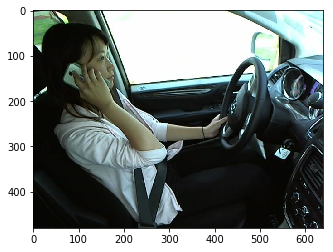

conv2d in :
Tensor("Reshape:0", shape=(1, 480, 640, 3), dtype=float32)
conv2d out :
Tensor("BiasAdd:0", shape=(1, 478, 638, 6), dtype=float32)
conv2d_relu in 
Tensor("BiasAdd:0", shape=(1, 478, 638, 6), dtype=float32)
conv2d_relu out 
Tensor("Relu:0", shape=(1, 478, 638, 6), dtype=float32)
conv2d_maxpool in  
Tensor("Relu:0", shape=(1, 478, 638, 6), dtype=float32)
conv2d_maxpool out 
Tensor("MaxPool:0", shape=(1, 238, 318, 6), dtype=float32)
conv2d in :
Tensor("MaxPool:0", shape=(1, 238, 318, 6), dtype=float32)
conv2d out :
Tensor("BiasAdd_1:0", shape=(1, 236, 316, 12), dtype=float32)
12
batch_normal in 
Tensor("BiasAdd_1:0", shape=(1, 236, 316, 12), dtype=float32)
Tensor("moments/mean:0", shape=(1, 1, 1, 12), dtype=float32) Tensor("moments/variance:0", shape=(1, 1, 1, 12), dtype=float32)
batch_normal BN_out 
Tensor("batchnorm/add_1:0", shape=(1, 236, 316, 12), dtype=float32)
batch_normal out 
Tensor("Relu_1:0", shape=(1, 236, 316, 12), dtype=float32)
conv2d_maxpool in  
Tensor("Relu_1

In [16]:
def get_one_image(img_dir):
    image = Image.open(img_dir)
    plt.imshow(image)
    plt.show()
    image = image.resize([640, 480])
    image_arr = np.array(image)
    return image_arr

def test(test_file):
    image_arr = get_one_image(test_file)
    image_arr = normalize(image_arr)
    with tf.Graph().as_default():
        image = tf.cast(image_arr, tf.float32)
        image = tf.reshape(image, [1,480,640,3])
        x = tf.placeholder(tf.float32,shape = [480,640,3])
        keep_prob = tf.placeholder(tf.float32,name='keep_prob') 
        logits = conv_net(image, keep_prob)
        cost = tf.nn.softmax(logits)
        saver = tf.train.Saver()

        with tf.Session() as sess:    
            sess.run(tf.global_variables_initializer())
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(coord=coord)  
            check_point_path = 'saved_model/' # 保存好模型的文件路径
            ckpt = tf.train.get_checkpoint_state(checkpoint_dir=check_point_path)
            saver.restore(sess,ckpt.model_checkpoint_path) 
            prediction = sess.run(cost, feed_dict={x:image_arr,keep_prob:1})
            max_index = np.argmax(prediction)
            print('预测的标签为：')
            print(max_index)
            print('预测的结果为：')
            print(prediction)
            if max_index==0:
                print('安全驾驶的可能性为 %.6f' %prediction[:, 0])
            elif max_index == 1:
                print('右手打字的可能性为 %.6f' %prediction[:, 1])
            elif max_index == 2:
                print('右手打电话的可能性为 %.6f' %prediction[:, 2])
            elif max_index == 3:
                print('左手打字的可能性为 %.6f' %prediction[:, 3])
            elif max_index == 4:
                print('左手打电话的可能性为 %.6f' %prediction[:, 4])            
            elif max_index == 5:
                print('调收音机的可能性为 %.6f' %prediction[:, 5])          
            elif max_index == 6:
                print('喝饮料的可能性为 %.6f' %prediction[:, 6])         
            elif max_index == 7:
                print('拿后面东西的可能性为 %.6f' %prediction[:, 7])       
            elif max_index == 8:
                print('整理头发和化妆的可能性为 %.6f' %prediction[:, 8])
            else :
                print('和其他乘客说话的可能性为 %.6f' %prediction[:, 9])
                
            coord.request_stop()
            coord.join(threads) 
            sess.close()
test('E:\\pythonProject\machineLearningProgress\\distracted_driver_detection\\distracted_driver_detection_dataset\\imgs\\test\\img_2.jpg')


## 迁移
